Checking the data, to get an idea of what columns etc.

In [150]:
import pandas as pd
acc = pd.read_csv("/Users/kunal/Code/Biometric Assignment/data/sample_data/2_PocketPhone_Accelerometer_(Samsung_S6).csv")
gyr = pd.read_csv("/Users/kunal/Code/Biometric Assignment/data/sample_data/2_PocketPhone_Gyroscope_(Samsung_S6).csv")
acc.head(), gyr.head()

(   EID    Xvalue     Yvalue    Zvalue                     time
 0    0  1.978808  -1.114501  3.514688  2017-04-17 14:44:43.026
 1    1  0.810437  -2.832341  2.801216  2017-04-17 14:44:43.036
 2    2 -0.252588  -5.337873  2.322376  2017-04-17 14:44:43.045
 3    3 -1.994370  -8.580819  0.926556  2017-04-17 14:44:43.057
 4    4 -3.323152 -11.498154 -0.196325  2017-04-17 14:44:43.066,
    EID    Xvalue    Yvalue    Zvalue                     time
 0    0  0.579504 -0.647681  0.233293  2017-04-17 14:44:43.026
 1    1  1.075917 -1.181378  0.243946  2017-04-17 14:44:43.036
 2    2  1.538242 -1.643703  0.274838  2017-04-17 14:44:43.045
 3    3  1.940912 -1.842908  0.297209  2017-04-17 14:44:43.057
 4    4  2.179531 -1.902562  0.373908  2017-04-17 14:44:43.066)

DEFINING Data Paths

In [151]:
DATA_ROOT = "data"
RAW_DIR = f"{DATA_ROOT}/sample_data"
PROCESSED_DIR = f"{DATA_ROOT}/processed_data"
OUT_X = f"{DATA_ROOT}/X.npy"
OUT_y = f"{DATA_ROOT}/y.npy"
OUT_X_CLEAN = f"{DATA_ROOT}/X_clean.npy"

Combining data from the gyroscope and the accelerometer to create a single 6 channel data stream

In [119]:
import os, re, pathlib as pl
import pandas as pd
import numpy as np

loading sensor data from the csv files

In [152]:
#function loads sensor data from a CSV, converts it to a standard 'time', 'x', 'y', 'z' format with correct data types, and cleans the resulting DataFrame.
def load_sensor_csv(path, time_col="time", x_col="X", y_col="Y", z_col="Z"):
    df = pd.read_csv(path, usecols=[time_col, x_col, y_col, z_col]).copy()
    df = df.rename(columns={time_col: "time", x_col: "x", y_col: "y", z_col: "z"})
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
   

    df = df.dropna(subset=["time"]).sort_values("time")
    df[["x","y","z"]] = df[["x","y","z"]].astype(float)
    return df

Resampling of data done below. This is to ensure that all 6 channels have the same reading at the same time.

In [153]:
def to_100hz(df):
    s = df.set_index('time').sort_index()
    # collapse duplicate timestamps (take mean), resample to 10 ms, interpolate tiny gaps
    s = s.groupby(level=0).mean()
    s = s.resample('10ms').mean().interpolate(limit_direction='both')
    return s

In [154]:
def merge_pair(acc_path, gyr_path, out_dir):
    acc = load_sensor_csv(acc_path)
    gyr = load_sensor_csv(gyr_path)

    acc100 = to_100hz(acc).add_prefix('acc_')
    gyr100 = to_100hz(gyr).add_prefix('gyr_')

    # keep only overlap
    start = max(acc100.index.min(), gyr100.index.min())
    end   = min(acc100.index.max(), gyr100.index.max())
    if not (start < end):
        raise ValueError(f"No overlap: {acc_path} | {gyr_path}")

    idx = pd.date_range(start, end, freq='10ms')
    acc100 = acc100.reindex(idx).interpolate(limit_direction='both')
    gyr100 = gyr100.reindex(idx).interpolate(limit_direction='both')

    merged = pd.concat([acc100, gyr100], axis=1).dropna()
    merged = merged.reset_index().rename(columns={'index':'time'})

    # output name: replace 'Accelerometer' → '6D' in the accelerometer filename
    base = pl.Path(acc_path).name
    out_name = re.sub(r'(?i)Accelerometer', '6D', base)
    out_path = pl.Path(out_dir) / out_name
    merged.to_csv(out_path, index=False)
    return str(out_path), len(merged)

In [155]:
#below we check if the accelerometer files has a corresponding gyroscope file with the same name. if so put them as a paired tuple 
pairs = []
for acc_path in acc_files:
    gyr_path = str(acc_path).replace("Accelerometer", "Gyroscope")
    if pl.Path(gyr_path).exists():
        pairs.append((str(acc_path), gyr_path))
    else:
        print("Skipping (no gyro found):", acc_path)

print(f"Found {len(pairs)} pairs")

Found 10 pairs


In [ ]:
ok, fail = 0, 0
for acc_path, gyr_path in pairs:
    try:
        out_path, n = merge_pair(acc_path, gyr_path, PROCESSED_DIR)
        ok += 1
        print(f"OK: {pl.Path(acc_path).name} + {pl.Path(gyr_path).name} -> {pl.Path(out_path).name} ({n} rows)")
    except Exception as e:
        fail += 1
        print(f"FAIL: {pl.Path(acc_path).name} | {pl.Path(gyr_path).name} :: {e}")

print(f"Done. success={ok}, failed={fail}")

After Comnbining the files into a single processed data file with 6 channels. we proceed to window it.

In [158]:
PROCESSED_DIR = "/Users/kunal/Code/Biometric Assignment/data/processed_data"
OUT_X = "/Users/kunal/Code/Biometric Assignment/data/X.npy"
OUT_y = "/Users/kunal/Code/Biometric Assignment/data/y.npy"

In [159]:
import pathlib as pl
import numpy as np
import pandas as pd

def subject_id_from_name(name):
    # e.g., "2_PocketPhone_6D_(Samsung_S6).csv" -> 2
    return int(name.split("_", 1)[0])

WIN = 500   # 5s * 100Hz
HOP = 250   # 50% overlap

Xs, ys = [], []

for csv_path in sorted(pl.Path(PROCESSED_DIR).glob("*.csv")):
    df = pd.read_csv(csv_path)
    X6 = df[["acc_x","acc_y","acc_z","gyr_x","gyr_y","gyr_z"]].to_numpy(dtype=float)

    # make windows
    for i in range(0, len(X6) - WIN + 1, HOP):
        win = X6[i:i+WIN]
        Xs.append(win)
        ys.append(subject_id_from_name(csv_path.name))

X = np.stack(Xs) if Xs else np.empty((0, WIN, 6))
y = np.array(ys, dtype=int)

np.save(OUT_X, X)
np.save(OUT_y, y)

print("X shape:", X.shape)  # (n_windows, 500, 6)
print("y shape:", y.shape)  # (n_windows,)
print("Subjects in y:", sorted(set(y.tolist())))
print("Saved to:", OUT_X, "and", OUT_y)

X shape: (14588, 500, 6)
y shape: (14588,)
Subjects in y: [2, 13, 23, 24, 49, 52, 55, 70, 78, 112]
Saved to: /Users/kunal/Code/Biometric Assignment/data/X.npy and /Users/kunal/Code/Biometric Assignment/data/y.npy


Data Cleaning -  using Z score clipping(outliers z>3 removed) and moving average smoothing.

In [160]:
import pandas as pd
import numpy as np

def clean_window(window, z_thresh=3, k=5):
    """
    window : (T, C) array (e.g. 500 x 6)
    z_thresh : z-score cutoff
    k : moving average window size
    """
    # z-score capping
    mean = window.mean(axis=0, keepdims=True)
    std  = window.std(axis=0, keepdims=True) + 1e-8
    z = (window - mean) / std
    window = np.clip(z, -z_thresh, z_thresh) * std + mean
    
    # simple moving average smoothing
    df = pd.DataFrame(window)
    window_smoothed = df.rolling(window=k, center=True, min_periods=1).mean().to_numpy()
    return window_smoothed

In [161]:
X = np.load("/Users/kunal/Code/Biometric Assignment/data/X.npy")
y = np.load("/Users/kunal/Code/Biometric Assignment/data/y.npy")

# Apply cleaning to each window
X_clean = np.array([clean_window(w) for w in X])

# Save for re-use
np.save("/Users/kunal/Code/Biometric Assignment/data/X_clean.npy", X_clean)
print("Cleaned windows saved -> X_clean.npy")

Cleaned windows saved -> X_clean.npy


In [162]:
X_PATH = "/Users/kunal/Code/Biometric Assignment/data/X_clean.npy"
Y_PATH = "/Users/kunal/Code/Biometric Assignment/data/y.npy"

In [163]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [164]:
X = np.load(X_PATH) 
y = np.load(Y_PATH)

Below we do Feature extraction where we provide around 16 features for each column . 16*6 leading up to 96 features in total.

In [165]:
def to_features_enhanced(X):
    """
    Extract comprehensive features from windowed data
    X: (N, T, C) where T=500, C=6
    Returns: (N, F) where F is total number of features
    """
    from scipy.stats import skew, kurtosis
    
    # Statistical features
    mean = X.mean(axis=1)                    # (N, 6)
    std = X.std(axis=1)                      # (N, 6)
    var = X.var(axis=1)                      # (N, 6)
    median = np.median(X, axis=1)            # (N, 6)
    q75 = np.percentile(X, 75, axis=1)       # (N, 6)
    q25 = np.percentile(X, 25, axis=1)       # (N, 6)
    iqr = q75 - q25                          # (N, 6)
    min_val = X.min(axis=1)                  # (N, 6)
    max_val = X.max(axis=1)                  # (N, 6)
    range_val = max_val - min_val            # (N, 6)
    
    # Energy and signal characteristics
    energy = (X**2).mean(axis=1)             # (N, 6)
    rms = np.sqrt(energy)                    # (N, 6)
    
    # Zero crossing rate (count sign changes)
    zero_crossings = ((X[:, :-1] * X[:, 1:]) < 0).sum(axis=1)  # (N, 6)
    
    # Mean absolute deviation
    mad = np.abs(X - mean[:, np.newaxis, :]).mean(axis=1)  # (N, 6)
    
    # Higher order moments
    skewness = skew(X, axis=1)               # (N, 6)
    kurt = kurtosis(X, axis=1)               # (N, 6)
    
    # Frequency domain features (FFT)
    fft_vals = np.fft.rfft(X, axis=1)
    fft_mag = np.abs(fft_vals)
    
    # Dominant frequency index
    dominant_freq_idx = fft_mag.argmax(axis=1)  # (N, 6)
    
    # Spectral energy
    spectral_energy = (fft_mag**2).sum(axis=1)  # (N, 6)
    
    # Concatenate all features
    feats = np.concatenate([
        mean, std, var, median, iqr, min_val, max_val, range_val,
        energy, rms, zero_crossings, mad, skewness, kurt,
        dominant_freq_idx, spectral_energy
    ], axis=1)
    
    return feats  # (N, 96) = 16 feature types × 6 channels

# Extract enhanced features
print("Extracting enhanced features...")
Xf_enhanced = to_features_enhanced(X)
print(f"Feature matrix shape: {Xf_enhanced.shape}")

Extracting enhanced features...
Feature matrix shape: (14588, 96)


In [166]:
Xf = to_features_enhanced(X)

For feature reduction we use SelectKBest (ANOVA F-value) to choose the top 10 features

In [167]:
from sklearn.feature_selection import SelectKBest, f_classif

# keep the 10 best features based on ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=10)
Xf_selected = selector.fit_transform(Xf, y)

# optional: see which features were chosen
mask = selector.get_support()
selected_indices = np.where(mask)[0]
print("Selected feature indices:", selected_indices.tolist())
print("Reduced feature matrix shape:", Xf_selected.shape)

Selected feature indices: [1, 2, 19, 20, 32, 38, 50, 56, 59, 92]
Reduced feature matrix shape: (14588, 10)


/Users/kunal/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [60 63 84 87] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/kunal/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Here we split train and test data

In [168]:
Xtr, Xte, ytr, yte = train_test_split(Xf, y, test_size=0.2, stratify=y, random_state=0)


Scaling features using Standard Scaler


In [169]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr)   # fit on train
Xte_s = scaler.transform(Xte)       # transform test

In [170]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


For Kfold cross validation

In [175]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
accs = []
reports = []
cms = []
loss_curves = []  # Added to track training loss curves for each fold

for fold, (train_idx, test_idx) in enumerate(kf.split(Xf_selected, y)):
    Xtr, Xte = Xf_selected[train_idx], Xf_selected[test_idx]
    ytr, yte = y[train_idx], y[test_idx]
    
    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(Xtr)
    Xte_s = scaler.transform(Xte)
    
    mlp = MLPClassifier(hidden_layer_sizes=(5, 5), activation="relu", solver="adam", max_iter=500, random_state=0)
    mlp.fit(Xtr_s, ytr)
    yp = mlp.predict(Xte_s)
    
    acc = accuracy_score(yte, yp)
    accs.append(acc)
    reports.append(classification_report(yte, yp, output_dict=True))
    cms.append(confusion_matrix(yte, yp))
    loss_curves.append(mlp.loss_curve_)  # Added to store the loss curve for this fold
    
    print(f"Fold {fold+1} accuracy: {acc:.4f}")

print(f"\nMean accuracy over {kf.get_n_splits()} folds: {np.mean(accs):.4f}")

Fold 1 accuracy: 0.9688
Fold 2 accuracy: 0.9743


/Users/kunal/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fold 3 accuracy: 0.9774
Fold 4 accuracy: 0.9647
Fold 5 accuracy: 0.9691

Mean accuracy over 5 folds: 0.9709


/Users/kunal/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


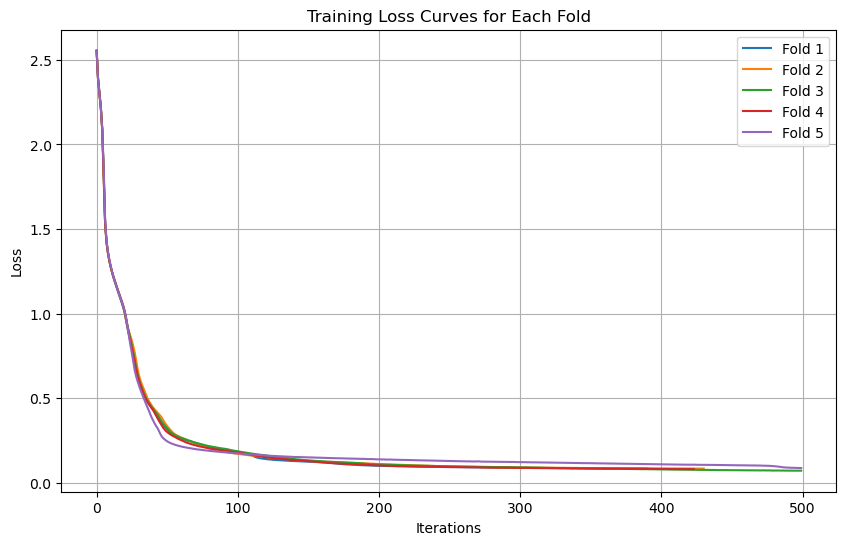

In [176]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for i, curve in enumerate(loss_curves):
    plt.plot(curve, label=f'Fold {i+1}')

plt.title('Training Loss Curves for Each Fold')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# After running K-Fold, suppose you have:
# accs: list of validation accuracies for each fold
# reports: list of classification_report dicts for each fold
# cms: list of confusion matrices for each fold
# histories: list of dicts with 'train_acc', 'val_acc', 'train_loss', 'val_loss' per epoch for each fold (if you record these during training)

# 1. Average accuracy
mean_acc = np.mean(accs)
std_acc = np.std(accs)
print(f"Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")

# 2. Precision, Recall, F1 (macro/weighted/class-wise)
precisions, recalls, f1s = [], [], []
for rep in reports:
    precisions.append([rep[str(cls)]['precision'] for cls in rep if cls.isdigit()])
    recalls.append([rep[str(cls)]['recall'] for cls in rep if cls.isdigit()])
    f1s.append([rep[str(cls)]['f1-score'] for cls in rep if cls.isdigit()])

precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)

print("Class-wise Precision (mean ± std):", np.mean(precisions, axis=0), np.std(precisions, axis=0))
print("Class-wise Recall (mean ± std):", np.mean(recalls, axis=0), np.std(recalls, axis=0))
print("Class-wise F1-score (mean ± std):", np.mean(f1s, axis=0), np.std(f1s, axis=0))

# Macro/weighted averages
macro_f1 = [rep['macro avg']['f1-score'] for rep in reports]
weighted_f1 = [rep['weighted avg']['f1-score'] for rep in reports]
print(f"Macro F1-score: {np.mean(macro_f1):.4f} ± {np.std(macro_f1):.4f}")
print(f"Weighted F1-score: {np.mean(weighted_f1):.4f} ± {np.std(weighted_f1):.4f}")

# 3. Confusion Matrix (mean over folds)
mean_cm = np.mean(np.array(cms), axis=0)
print("Mean Confusion Matrix over folds:\n", mean_cm.astype(int))

# 4. Plots: Training/Validation Accuracy and Loss over epochs
# histories: list of dicts with keys 'train_acc', 'val_acc', 'train_loss', 'val_loss'


Mean Accuracy: 0.9709 ± 0.0045
Class-wise Precision (mean ± std): [0.94486483 0.94534444 0.98489993 0.96759565 0.99566799 0.92609132
 0.99106004 0.90213317 0.99663866 0.92240543] [0.02852102 0.01947376 0.01433257 0.02676856 0.00205015 0.03315933
 0.00974126 0.06188656 0.00672269 0.04141059]
Class-wise Recall (mean ± std): [0.97004658 0.91920007 0.95539621 0.96610527 0.99136    0.92700665
 0.99177967 0.91785858 0.99143826 0.94949647] [0.01079272 0.02421689 0.02137277 0.03205021 0.00222854 0.03501214
 0.00368456 0.06850421 0.00540568 0.02650774]
Class-wise F1-score (mean ± std): [0.95710871 0.93164617 0.96974243 0.96606267 0.99350577 0.92591462
 0.99139403 0.90551452 0.99399841 0.93465228] [0.01747809 0.00914928 0.0127532  0.01150996 0.00102849 0.02409196
 0.00537728 0.02026893 0.00207939 0.0148985 ]
Macro F1-score: 0.9570 ± 0.0069
Weighted F1-score: 0.9710 ± 0.0046
Mean Confusion Matrix over folds:
 [[ 155    1    0    0    2    0    0    1    0    0]
 [   4  136    0    0    2    0    

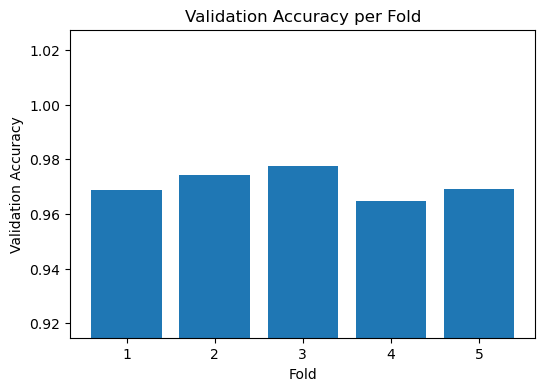

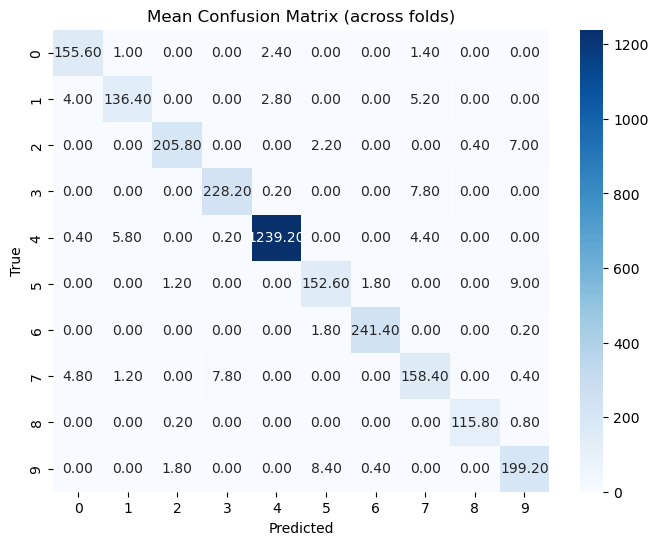

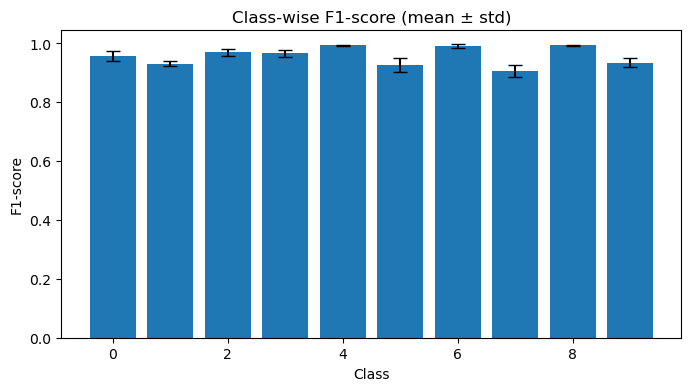

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
# Plot accuracy for each fold with zoomed y-axis
plt.figure(figsize=(6,4))
plt.bar(range(1, len(accs)+1), accs)
plt.xlabel('Fold')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy per Fold')
plt.ylim(min(accs)-0.05, max(accs)+0.05)  # Zoom to accuracy range with small margin
plt.show()

# Plot mean confusion matrix (fix: use fmt='.2f' for float values)
plt.figure(figsize=(8,6))
sns.heatmap(mean_cm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Mean Confusion Matrix (across folds)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot class-wise F1-score mean and std
f1_mean = np.mean(f1s, axis=0)
f1_std = np.std(f1s, axis=0)
plt.figure(figsize=(8,4))
plt.bar(range(len(f1_mean)), f1_mean, yerr=f1_std, capsize=5)
plt.xlabel('Class')
plt.ylabel('F1-score')
plt.title('Class-wise F1-score (mean ± std)')
plt.show()

LSTM
Below we set up the LSTM network for user identification.
Sticking to assignment constraints of lesser than 6 neurons per layer.


In [ ]:
# Basic Imports & setup
import os, random, numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, utils

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
X = np.load("data/X_clean.npy")  
y = np.load("data/y.npy")        # expected: (N,)

print("X shape:", X.shape, "y shape:", y.shape, "unique classes:", np.unique(y))


X shape: (14588, 500, 6) y shape: (14588,) unique classes: [  2  13  23  24  49  52  55  70  78 112]


In [ ]:
#inspecting labels
print("y shape:", y.shape, "dtype:", y.dtype)
print("unique labels (first 20):", np.unique(y)[:20])
print("min/max label:", np.min(y), np.max(y))

y_flat = np.ravel(y)

y shape: (14588,) dtype: int64
unique labels (first 20): [  2  13  23  24  49  52  55  70  78 112]
min/max label: 2 112


Converting data from different classes and mapping them form 1-9;

In [188]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_idx = le.fit_transform(y_flat)          # now in 0..K-1
num_classes = len(le.classes_)            # correct K

# One-hot for Keras
from tensorflow.keras import utils
y_cat = utils.to_categorical(y_idx, num_classes=num_classes)

# (Optional) keep a mapping to go back from indices to original labels
index_to_label = {i: lab for i, lab in enumerate(le.classes_)}
label_to_index = {lab: i for i, lab in enumerate(le.classes_)}
print(f"{num_classes} classes remapped to 0..{num_classes-1}")


10 classes remapped to 0..9


In [ ]:
#scaling data using standard scalar
N, T, F = X.shape
scaler = StandardScaler()
X_2d = X.reshape(-1, F)              # (N*T, 6)
X_2d_scaled = scaler.fit_transform(X_2d)
X_scaled = X_2d_scaled.reshape(N, T, F)
num_classes = len(np.unique(y))

# One-hot for Keras
y_cat = utils.to_categorical(y_idx, num_classes=num_classes)


In [ ]:
# Defining the LSTM Model(within assignment constraints)
def make_lstm_model(timesteps, features, num_classes, lstm_layers=3, units=6, dropout=0.2):
    
    assert 1 <= lstm_layers <= 5, "lstm_layers must be between 1 and 5"
    assert units <= 6, "units must be <= 6"

    inputs = layers.Input(shape=(timesteps, features))
    x = inputs
    for i in range(lstm_layers):
        # return_sequences=True for all but last layer
        rs = i < (lstm_layers - 1)
        x = layers.LSTM(units, return_sequences=rs)(x)
        x = layers.Dropout(dropout)(x)

    # Classification head
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Quick summary
tmp_model = make_lstm_model(T, F, num_classes, lstm_layers=3, units=6, dropout=0.2)
tmp_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 500, 6)]          0         
                                                                 
 lstm_56 (LSTM)              (None, 500, 6)            312       
                                                                 
 dropout_6 (Dropout)         (None, 500, 6)            0         
                                                                 
 lstm_57 (LSTM)              (None, 500, 6)            312       
                                                                 
 dropout_7 (Dropout)         (None, 500, 6)            0         
                                                                 
 lstm_58 (LSTM)              (None, 6)                 312       
                                                                 
 dropout_8 (Dropout)         (None, 6)                 0   

In [194]:
from sklearn.preprocessing import LabelEncoder
# y may be shape (N,1); flatten to (N,)
y_flat = np.ravel(y)
le = LabelEncoder()
y_idx = le.fit_transform(y_flat)       # now 0..K-1
num_classes = len(le.classes_)
print("remapped classes:", num_classes)

remapped classes: 10


In [196]:
# Block 4 (fixed): Stratified K-Fold training with y_idx throughout
K = 5
EPOCHS = 30
BATCH_SIZE = 64
PATIENCE = 6

skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)

histories = []
oof_true = []
oof_pred = []
oof_pred_proba = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(X_scaled, y_idx), 1):
    print(f"\n=== Fold {fold}/{K} ===")
    X_tr, X_va = X_scaled[tr_idx], X_scaled[va_idx]

    # One-hot using the REMAPPED indices
    y_tr = utils.to_categorical(y_idx[tr_idx], num_classes=num_classes)
    y_va = utils.to_categorical(y_idx[va_idx], num_classes=num_classes)

    # Class weights must be keyed 0..num_classes-1
    cw_vals = class_weight.compute_class_weight(
        class_weight="balanced",
        classes=np.arange(num_classes),
        y=y_idx[tr_idx]
    )
    cw = {int(i): float(w) for i, w in enumerate(cw_vals)}

    # Force CPU usage to avoid device mismatch errors
    with tf.device('/CPU:0'):
        model = make_lstm_model(T, F, num_classes, lstm_layers=3, units=6, dropout=0.2)

        es = callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
        rlrop = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

        hist = model.fit(
            X_tr, y_tr,
            validation_data=(X_va, y_va),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            class_weight=cw,
            callbacks=[es, rlrop],
            verbose=1
        )
    histories.append(hist.history)

    # OOF predictions for global metrics
    va_proba = model.predict(X_va, verbose=0)
    va_pred = np.argmax(va_proba, axis=1)

    oof_pred.append(va_pred)
    oof_pred_proba.append(va_proba)
    oof_true.append(y_idx[va_idx])  # use the remapped integer labels here

# Concatenate across folds
oof_true = np.concatenate(oof_true)
oof_pred = np.concatenate(oof_pred)
oof_pred_proba = np.concatenate(oof_pred_proba, axis=0)
print("OOF accuracy:", accuracy_score(oof_true, oof_pred))


=== Fold 1/5 ===
Epoch 1/30
183/183 [==============================] - 36s 174ms/step - loss: 1.9397 - accuracy: 0.2404 - val_loss: 1.6493 - val_accuracy: 0.3509 - lr: 0.0010
Epoch 2/30
183/183 [==============================] - 31s 170ms/step - loss: 1.3611 - accuracy: 0.4237 - val_loss: 1.3216 - val_accuracy: 0.6093 - lr: 0.0010
Epoch 3/30
183/183 [==============================] - 30s 163ms/step - loss: 1.1582 - accuracy: 0.5584 - val_loss: 1.0679 - val_accuracy: 0.8516 - lr: 0.0010
Epoch 4/30
183/183 [==============================] - 30s 163ms/step - loss: 1.0363 - accuracy: 0.6451 - val_loss: 0.9473 - val_accuracy: 0.8468 - lr: 0.0010
Epoch 5/30
183/183 [==============================] - 30s 163ms/step - loss: 0.9629 - accuracy: 0.6403 - val_loss: 0.8725 - val_accuracy: 0.8468 - lr: 0.0010
Epoch 6/30
183/183 [==============================] - 30s 163ms/step - loss: 0.8854 - accuracy: 0.6422 - val_loss: 0.8608 - val_accuracy: 0.8338 - lr: 0.0010
Epoch 7/30
183/183 [==============

2025-10-13 15:08:47.425091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 15:08:47.670720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 15:08:47.789227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 15:08:47.865237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



=== Fold 2/5 ===
Epoch 1/30
183/183 [==============================] - 41s 188ms/step - loss: 2.0434 - accuracy: 0.1747 - val_loss: 1.8525 - val_accuracy: 0.2238 - lr: 0.0010
Epoch 2/30
183/183 [==============================] - 30s 163ms/step - loss: 1.6636 - accuracy: 0.3360 - val_loss: 1.5726 - val_accuracy: 0.2776 - lr: 0.0010
Epoch 3/30
183/183 [==============================] - 30s 162ms/step - loss: 1.4715 - accuracy: 0.3822 - val_loss: 1.4566 - val_accuracy: 0.4719 - lr: 0.0010
Epoch 4/30
183/183 [==============================] - 30s 161ms/step - loss: 1.3610 - accuracy: 0.4350 - val_loss: 1.3737 - val_accuracy: 0.4931 - lr: 0.0010
Epoch 5/30
183/183 [==============================] - 30s 162ms/step - loss: 1.2941 - accuracy: 0.4864 - val_loss: 1.2851 - val_accuracy: 0.5696 - lr: 0.0010
Epoch 6/30
183/183 [==============================] - 30s 161ms/step - loss: 1.2715 - accuracy: 0.5237 - val_loss: 1.1848 - val_accuracy: 0.5617 - lr: 0.0010
Epoch 7/30
183/183 [==============

2025-10-13 15:46:29.903286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 15:46:30.089099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 15:46:30.277881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 15:46:30.355440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



=== Fold 3/5 ===
Epoch 1/30
183/183 [==============================] - 33s 166ms/step - loss: 2.0664 - accuracy: 0.1709 - val_loss: 1.8454 - val_accuracy: 0.2413 - lr: 0.0010
Epoch 2/30
183/183 [==============================] - 30s 163ms/step - loss: 1.5734 - accuracy: 0.3365 - val_loss: 1.4483 - val_accuracy: 0.3077 - lr: 0.0010
Epoch 3/30
183/183 [==============================] - 30s 165ms/step - loss: 1.3890 - accuracy: 0.4285 - val_loss: 1.2866 - val_accuracy: 0.6974 - lr: 0.0010
Epoch 4/30
183/183 [==============================] - 30s 164ms/step - loss: 1.2610 - accuracy: 0.4075 - val_loss: 1.2074 - val_accuracy: 0.3670 - lr: 0.0010
Epoch 5/30
183/183 [==============================] - 30s 164ms/step - loss: 1.1976 - accuracy: 0.4805 - val_loss: 1.0171 - val_accuracy: 0.7766 - lr: 0.0010
Epoch 6/30
183/183 [==============================] - 31s 168ms/step - loss: 1.1341 - accuracy: 0.5241 - val_loss: 1.0202 - val_accuracy: 0.8091 - lr: 0.0010
Epoch 7/30
183/183 [==============

2025-10-13 15:53:09.624913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 15:53:09.771892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 15:53:09.876329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 15:53:09.976340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



=== Fold 4/5 ===
Epoch 1/30
183/183 [==============================] - 32s 162ms/step - loss: 2.0636 - accuracy: 0.2068 - val_loss: 1.8859 - val_accuracy: 0.3130 - lr: 0.0010
Epoch 2/30
183/183 [==============================] - 29s 160ms/step - loss: 1.5891 - accuracy: 0.6094 - val_loss: 1.1566 - val_accuracy: 0.7833 - lr: 0.0010
Epoch 3/30
183/183 [==============================] - 29s 161ms/step - loss: 1.3502 - accuracy: 0.6972 - val_loss: 1.0332 - val_accuracy: 0.7576 - lr: 0.0010
Epoch 4/30
183/183 [==============================] - 30s 161ms/step - loss: 1.2709 - accuracy: 0.6819 - val_loss: 0.8796 - val_accuracy: 0.7758 - lr: 0.0010
Epoch 5/30
183/183 [==============================] - 29s 160ms/step - loss: 1.2471 - accuracy: 0.6269 - val_loss: 0.8554 - val_accuracy: 0.7748 - lr: 0.0010
Epoch 6/30
183/183 [==============================] - 29s 160ms/step - loss: 1.1381 - accuracy: 0.7152 - val_loss: 0.7558 - val_accuracy: 0.7871 - lr: 0.0010
Epoch 7/30
183/183 [==============

2025-10-13 16:02:12.313917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 16:02:12.498536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 16:02:12.627424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 16:02:12.707110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



=== Fold 5/5 ===
Epoch 1/30
183/183 [==============================] - 35s 168ms/step - loss: 2.1117 - accuracy: 0.1955 - val_loss: 1.8710 - val_accuracy: 0.2283 - lr: 0.0010
Epoch 2/30
183/183 [==============================] - 30s 165ms/step - loss: 1.6210 - accuracy: 0.3460 - val_loss: 1.4648 - val_accuracy: 0.7281 - lr: 0.0010
Epoch 3/30
183/183 [==============================] - 30s 165ms/step - loss: 1.3686 - accuracy: 0.6471 - val_loss: 1.2334 - val_accuracy: 0.7199 - lr: 0.0010
Epoch 4/30
183/183 [==============================] - 30s 166ms/step - loss: 1.2437 - accuracy: 0.6303 - val_loss: 1.0652 - val_accuracy: 0.7425 - lr: 0.0010
Epoch 5/30
183/183 [==============================] - 30s 165ms/step - loss: 1.1052 - accuracy: 0.6484 - val_loss: 1.0076 - val_accuracy: 0.7501 - lr: 0.0010
Epoch 6/30
183/183 [==============================] - 30s 165ms/step - loss: 1.0687 - accuracy: 0.6546 - val_loss: 0.9865 - val_accuracy: 0.7532 - lr: 0.0010
Epoch 7/30
183/183 [==============

2025-10-13 16:17:39.454773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 16:17:39.629708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 16:17:39.794489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 16:17:39.883401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


OOF accuracy: 0.7990814367973677


In [197]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = [str(c) for c in le.classes_]
print("\n=== Classification Report (OOF) ===")
print(classification_report(oof_true, oof_pred, target_names=target_names, digits=4))

cm = confusion_matrix(oof_true, oof_pred)
print("\nConfusion Matrix (rows=true, cols=pred):\n", cm)


=== Classification Report (OOF) ===
              precision    recall  f1-score   support

           2     0.5389    0.6820    0.6021       802
          13     0.7395    0.6887    0.7132       742
          23     0.8209    0.7066    0.7595      1077
          24     0.8989    0.6173    0.7319      1181
          49     0.9558    0.9336    0.9446      6250
          52     0.4793    0.6185    0.5401       823
          55     0.7573    0.8307    0.7923      1217
          70     0.6452    0.6848    0.6644       863
          78     0.6838    0.9589    0.7983       584
         112     0.6648    0.5748    0.6166      1049

    accuracy                         0.7991     14588
   macro avg     0.7184    0.7296    0.7163     14588
weighted avg     0.8137    0.7991    0.8015     14588


Confusion Matrix (rows=true, cols=pred):
 [[ 547   11   12    7  203    0    6   12    4    0]
 [  42  511    1   15    1    0   12  156    4    0]
 [   9    0  761    3   38    8   22    7  222    7]
 [

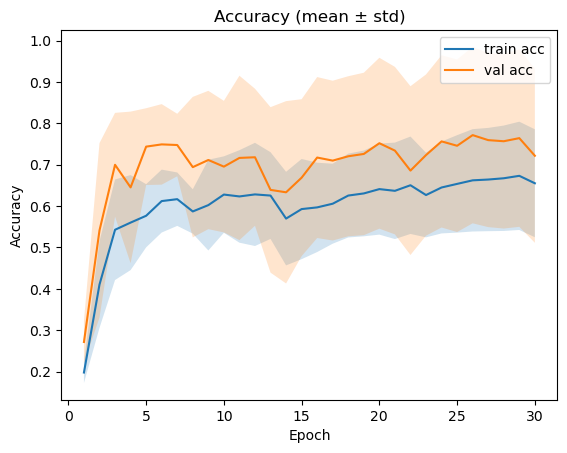

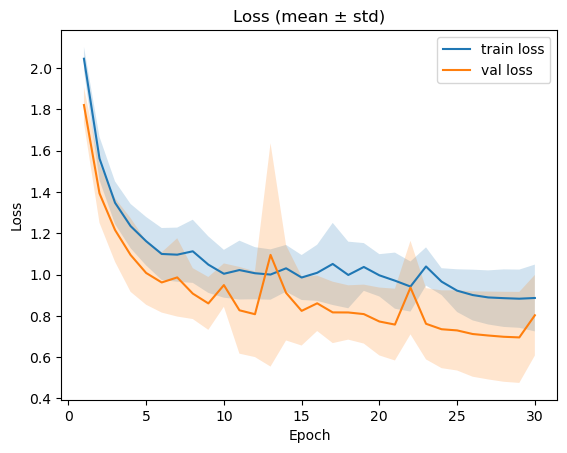

In [198]:
import numpy as np
import matplotlib.pyplot as plt

def _stack_histories(key):
    max_len = max(len(h[key]) for h in histories)
    arr = []
    for h in histories:
        vec = h[key]
        if len(vec) < max_len:
            vec = vec + [vec[-1]] * (max_len - len(vec))
        arr.append(vec)
    return np.array(arr)

acc_tr = _stack_histories("accuracy")
acc_va = _stack_histories("val_accuracy")
loss_tr = _stack_histories("loss")
loss_va = _stack_histories("val_loss")
epochs = np.arange(1, acc_tr.shape[1] + 1)

plt.figure()
plt.plot(epochs, acc_tr.mean(axis=0), label="train acc")
plt.fill_between(epochs, acc_tr.mean(axis=0)-acc_tr.std(axis=0),
                 acc_tr.mean(axis=0)+acc_tr.std(axis=0), alpha=0.2)
plt.plot(epochs, acc_va.mean(axis=0), label="val acc")
plt.fill_between(epochs, acc_va.mean(axis=0)-acc_va.std(axis=0),
                 acc_va.mean(axis=0)+acc_va.std(axis=0), alpha=0.2)
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy (mean ± std)"); plt.legend(); plt.show()

plt.figure()
plt.plot(epochs, loss_tr.mean(axis=0), label="train loss")
plt.fill_between(epochs, loss_tr.mean(axis=0)-loss_tr.std(axis=0),
                 loss_tr.mean(axis=0)+loss_tr.std(axis=0), alpha=0.2)
plt.plot(epochs, loss_va.mean(axis=0), label="val loss")
plt.fill_between(epochs, loss_va.mean(axis=0)-loss_va.std(axis=0),
                 loss_va.mean(axis=0)+loss_va.std(axis=0), alpha=0.2)
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss (mean ± std)"); plt.legend(); plt.show()

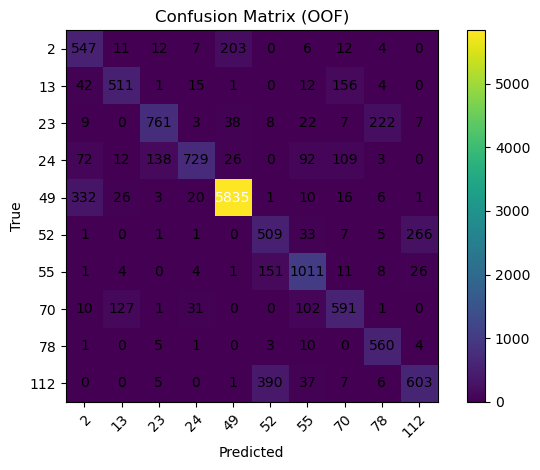

In [199]:
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(target_names)),
    yticks=np.arange(len(target_names)),
    xticklabels=target_names,
    yticklabels=target_names,
    xlabel="Predicted",
    ylabel="True",
    title="Confusion Matrix (OOF)"
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

In [200]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# oof_pred_proba is (N, num_classes)
# Compute macro/micro AUCs
try:
    macro_auc = roc_auc_score(
        np.eye(num_classes)[oof_true],  # one-hot true
        oof_pred_proba,
        average="macro",
        multi_class="ovr"
    )
    micro_auc = roc_auc_score(
        np.eye(num_classes)[oof_true],
        oof_pred_proba,
        average="micro",
        multi_class="ovr"
    )
    print(f"Macro AUC: {macro_auc:.4f} | Micro AUC: {micro_auc:.4f}")
except Exception as e:
    print("AUC computation skipped:", e)

Macro AUC: 0.9664 | Micro AUC: 0.9704


In [203]:
OUTPUT_DIR = Path("data/outputs")   # <-- change to Path("/mnt/data/outputs") if you prefer

# Create the directory (and parents) if it doesn't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Save files
np.save(OUTPUT_DIR / "oof_true.npy", oof_true)
np.save(OUTPUT_DIR / "oof_pred.npy", oof_pred)
np.save(OUTPUT_DIR / "oof_proba.npy", oof_pred_proba)
np.save(OUTPUT_DIR / "confusion_matrix.npy", cm)
np.save(OUTPUT_DIR / "label_classes.npy", le.classes_)

print(f"Saved artifacts to: {OUTPUT_DIR.resolve()}")
print("Files:", [p.name for p in OUTPUT_DIR.iterdir()])

Saved artifacts to: /Users/kunal/Code/Biometric Assignment/data/outputs
Files: ['oof_pred.npy', 'oof_proba.npy', 'confusion_matrix.npy', 'oof_true.npy', 'label_classes.npy']


,class,precision,recall,f1,support
0,49,0.955774,0.933600,0.944557,6250
1,78,0.683761,0.958904,0.798289,584
2,55,0.757303,0.830731,0.792320,1217
3,23,0.820928,0.706592,0.759481,1077
4,24,0.898890,0.617273,0.731928,1181
5,13,0.739508,0.688679,0.713189,742
6,70,0.645197,0.684820,0.664418,863
7,112,0.664829,0.574833,0.616564,1049
8,2,0.538916,0.682045,0.602091,802
9,52,0.479284,0.618469,0.540053,823


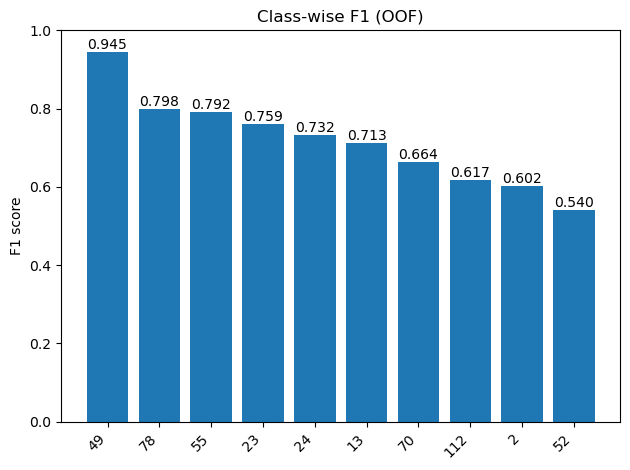

Saved class-wise F1 table to data/outputs/classwise_f1_oof.csv


In [206]:
labels_idx = np.arange(num_classes)                 # 0..K-1
class_names = [str(c) for c in le.classes_]         # pretty labels

prec, rec, f1, support = precision_recall_fscore_support(
    oof_true, oof_pred, labels=labels_idx, zero_division=0
)

# Table (DataFrame)
df_cls = pd.DataFrame({
    "class": class_names,
    "precision": prec,
    "recall": rec,
    "f1": f1,
    "support": support
}).sort_values("f1", ascending=False).reset_index(drop=True)

display(df_cls)

# --- Plot bar chart (sorted by F1 desc) ---
sorted_idx = np.argsort(f1)[::-1]
sorted_f1 = f1[sorted_idx]
sorted_names = [class_names[i] for i in sorted_idx]

plt.figure()
bars = plt.bar(np.arange(len(sorted_f1)), sorted_f1)
for i, v in enumerate(sorted_f1):
    plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
plt.xticks(np.arange(len(sorted_names)), sorted_names, rotation=45, ha="right")
plt.ylim(0, 1)
plt.ylabel("F1 score")
plt.title("Class-wise F1 (OOF)")
plt.tight_layout()
plt.show()

# (Optional) save CSV
outdir = Path("data/outputs")
outdir.mkdir(parents=True, exist_ok=True)
df_cls.to_csv(outdir / "classwise_f1_oof.csv", index=False)
print(f"Saved class-wise F1 table to {outdir/'classwise_f1_oof.csv'}")

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve


def make_binary_labels(y_idx, target_class_index):
    """
    Create binary labels for a specific user:
      genuine=1 for target_class_index, impostor=0 for all others.
    """
    y_bin = (y_idx == target_class_index).astype(np.int32)
    return y_bin

# --- 2) Class-imbalance aware splitter -------------------------------------
def get_binary_cv_splits(y_bin, n_splits=5, seed=42):
    """
    Stratified K-Fold on binary labels to preserve genuine/impostor ratio.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    return list(skf.split(np.zeros_like(y_bin), y_bin))  # X is dummy here

# --- 3) Metrics: FAR, FRR, EER, AUC ----------------------------------------
def far_frr_at_threshold(y_true, y_scores, thresh):
    """
    FAR = fraction of impostors (y=0) incorrectly accepted (score>=thresh)
    FRR = fraction of genuines (y=1) incorrectly rejected (score<thresh)
    """
    y_true = np.asarray(y_true).astype(int)
    y_scores = np.asarray(y_scores)

    # Predictions: accept if score >= thresh
    y_pred = (y_scores >= thresh).astype(int)

    # Masks
    impostor_mask = (y_true == 0)
    genuine_mask  = (y_true == 1)

    # Handle edge-cases (e.g., if a fold has only one class — shouldn't happen with stratification)
    far = ( (y_pred[impostor_mask] == 1).sum() / max(1, impostor_mask.sum()) )
    frr = ( (y_pred[genuine_mask]  == 0).sum() / max(1, genuine_mask.sum()) )
    return far, frr

def compute_eer(y_true, y_scores):
    """
    EER: threshold where FAR ~= FRR. We search over all unique score thresholds.
    Returns (eer, eer_threshold, far_curve, frr_curve, thresholds).
    """
    y_true = np.asarray(y_true).astype(int)
    y_scores = np.asarray(y_scores)

    # Use ROC thresholds as a good candidate set to search
    fpr, tpr, thr = roc_curve(y_true, y_scores, drop_intermediate=False)
    # FAR at ROC is fpr; FRR = 1 - tpr, but thresholds go high->low. We want exact FAR/FRR via our function.
    # We'll still refine using all distinct thresholds from scores.
    thresholds = np.unique(np.r_[thr, y_scores.min()-1e-12, y_scores.max()+1e-12])

    fars, frrs = [], []
    for t in thresholds:
        far, frr = far_frr_at_threshold(y_true, y_scores, t)
        fars.append(far)
        frrs.append(frr)
    fars = np.array(fars); frrs = np.array(frrs)

    # EER is the point where |FAR-FRR| is minimized
    idx = np.argmin(np.abs(fars - frrs))
    eer = 0.5 * (fars[idx] + frrs[idx])  # average at the crossing
    eer_thresh = thresholds[idx]
    return float(eer), float(eer_thresh), fars, frrs, thresholds

def compute_auc(y_true, y_scores):
    """
    Standard Area Under the ROC Curve (AUC).
    """
    try:
        return float(roc_auc_score(y_true, y_scores))
    except ValueError:
        # If a fold has a single class (shouldn't with stratification), return NaN
        return float("nan")


def make_simple_10_features(X_seq):
    """
    Baseline 10-D features from sequences: mean(6) + std(4 of the 6) = 10 dims.
    Replace this with your real 10 selected features from Part 2 if you have them.
    """
    # X_seq: (N, T, F=6)
    means = X_seq.mean(axis=1)             # (N, 6)
    stds  = X_seq.std(axis=1)              # (N, 6)
    # pick 4 std channels (example: first 4) to total 10 features
    X10 = np.concatenate([means, stds[:, :4]], axis=1)  # (N, 10)
    return X10

X_feat10 = make_simple_10_features(X_scaled)

print("Helpers ready. For users:", list(le.classes_))
print("Feature shapes -> LSTM seq:", X_scaled.shape, " | FNN fea:", X_feat10.shape)

Helpers ready. For users: [2, 13, 23, 24, 49, 52, 55, 70, 78, 112]
Feature shapes -> LSTM seq: (14588, 500, 6)  | FNN fea: (14588, 10)


In [208]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# --- Optimizer: legacy Adam if available (stabler on some setups) ---
try:
    from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
    AdamOpt = LegacyAdam
except Exception:
    from tensorflow.keras.optimizers import Adam as AdamOpt

# --- FNN builder (within assignment constraints: ≤5 hidden layers, ≤6 units each) ---
def make_ffnn(input_dim, hidden_layers=3, units=6, dropout=0.2):
    assert 1 <= hidden_layers <= 5, "hidden_layers must be 1..5"
    assert units <= 6, "units must be ≤ 6"

    inputs = layers.Input(shape=(input_dim,))
    x = inputs
    for _ in range(hidden_layers):
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
    # Binary output
    out = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, out)
    model.compile(
        optimizer=AdamOpt(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
        jit_compile=False
    )
    return model

# --- CV + train for each user ---
K_VER = 5
EPOCHS = 40
BATCH_SIZE = 128
PATIENCE = 6

user_metrics = []   # will hold dicts: {"user": orig_label, "AUC": ..., "EER": ..., "FAR@EER": ..., "FRR@EER": ...}

for user_idx, orig_label in enumerate(le.classes_):
    print(f"\n======================")
    print(f"User {user_idx} (orig id: {orig_label}) — One-vs-All FNN")
    print(f"======================")

    # Binary labels: genuine=1 for this user, impostor=0 for others
    y_bin = make_binary_labels(y_idx, target_class_index=user_idx)

    # Stratified CV to keep class ratio consistent
    splits = get_binary_cv_splits(y_bin, n_splits=K_VER, seed=SEED)

    fold_aucs, fold_eers, fold_fars, fold_frrs = [], [], [], []

    for fold, (tr_idx, va_idx) in enumerate(splits, 1):
        # Clear session between folds (keeps things clean)
        tf.keras.backend.clear_session()

        Xtr, Xva = X_feat10[tr_idx], X_feat10[va_idx]
        ytr, yva = y_bin[tr_idx], y_bin[va_idx]

        # Class weights for imbalance (keys must be 0 and 1)
        cw_vals = class_weight.compute_class_weight(
            class_weight="balanced",
            classes=np.array([0, 1], dtype=int),
            y=ytr
        )
        cw = {0: float(cw_vals[0]), 1: float(cw_vals[1])}

        model = make_ffnn(input_dim=X_feat10.shape[1], hidden_layers=3, units=6, dropout=0.2)

        es = callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
        rlrop = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

        with tf.device("/CPU:0"):  # safe default
            model.fit(
                Xtr, ytr,
                validation_data=(Xva, yva),
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                class_weight=cw,
                callbacks=[es, rlrop],
                verbose=0
            )

        # Scores = sigmoid probabilities (acceptance score for "genuine")
        y_scores = model.predict(Xva, verbose=0).ravel()

        # Metrics
        auc_val = compute_auc(yva, y_scores)
        eer, eer_thr, fars, frrs, thrs = compute_eer(yva, y_scores)
        # Record FAR and FRR at the EER threshold
        far_eer, frr_eer = far_frr_at_threshold(yva, y_scores, eer_thr)

        fold_aucs.append(auc_val)
        fold_eers.append(eer)
        fold_fars.append(far_eer)
        fold_frrs.append(frr_eer)

        print(f"  Fold {fold}: AUC={auc_val:.4f} | EER={eer:.4f} | FAR@EER={far_eer:.4f} | FRR@EER={frr_eer:.4f}")

    # Per-user averages across folds
    user_summary = {
        "user": orig_label,
        "AUC": float(np.nanmean(fold_aucs)),
        "EER": float(np.nanmean(fold_eers)),
        "FAR@EER": float(np.nanmean(fold_fars)),
        "FRR@EER": float(np.nanmean(fold_frrs)),
    }
    user_metrics.append(user_summary)

    print(f"--> User {orig_label} mean over {K_VER} folds | "
          f"AUC={user_summary['AUC']:.4f}, EER={user_summary['EER']:.4f}, "
          f"FAR@EER={user_summary['FAR@EER']:.4f}, FRR@EER={user_summary['FRR@EER']:.4f}")

# --- Aggregate across all 10 users ---
AUCs  = [m["AUC"] for m in user_metrics]
EERs  = [m["EER"] for m in user_metrics]
FARsE = [m["FAR@EER"] for m in user_metrics]
FRRsE = [m["FRR@EER"] for m in user_metrics]

print("\n===== Overall (mean across 10 users) =====")
print(f"Mean AUC: {np.mean(AUCs):.4f} ± {np.std(AUCs):.4f}")
print(f"Mean EER: {np.mean(EERs):.4f} ± {np.std(EERs):.4f}")
print(f"Mean FAR@EER: {np.mean(FARsE):.4f} ± {np.std(FARsE):.4f}")
print(f"Mean FRR@EER: {np.mean(FRRsE):.4f} ± {np.std(FRRsE):.4f}")

# (Optional) nice table
import pandas as pd
df_users = pd.DataFrame(user_metrics)
display(df_users.sort_values("EER"))


User 0 (orig id: 2) — One-vs-All FNN


2025-10-13 21:12:58.053427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:12:59.172137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:13:12.846739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 1: AUC=0.9970 | EER=0.0068 | FAR@EER=0.0073 | FRR@EER=0.0063


2025-10-13 21:13:14.226208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:13:14.705529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:13:25.419075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 2: AUC=0.9986 | EER=0.0062 | FAR@EER=0.0062 | FRR@EER=0.0062


2025-10-13 21:13:26.276703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:13:26.805280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:13:38.864548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 3: AUC=0.9978 | EER=0.0062 | FAR@EER=0.0062 | FRR@EER=0.0062


2025-10-13 21:13:39.758553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:13:43.439176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:13:58.383428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 4: AUC=0.9996 | EER=0.0011 | FAR@EER=0.0022 | FRR@EER=0.0000


2025-10-13 21:13:59.264810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:13:59.771432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:14:15.672145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 5: AUC=0.9993 | EER=0.0055 | FAR@EER=0.0047 | FRR@EER=0.0063
--> User 2 mean over 5 folds | AUC=0.9985, EER=0.0051, FAR@EER=0.0053, FRR@EER=0.0050

User 1 (orig id: 13) — One-vs-All FNN


2025-10-13 21:14:16.525245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:14:17.021256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:14:26.910596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 1: AUC=0.9944 | EER=0.0147 | FAR@EER=0.0159 | FRR@EER=0.0135


2025-10-13 21:14:27.687331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:14:28.166587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:14:34.465936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 2: AUC=0.9920 | EER=0.0202 | FAR@EER=0.0202 | FRR@EER=0.0201


2025-10-13 21:14:35.137351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:14:35.605443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:14:49.120869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 3: AUC=0.9953 | EER=0.0268 | FAR@EER=0.0267 | FRR@EER=0.0268


2025-10-13 21:14:49.873906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:14:50.353054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:15:03.760769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 4: AUC=0.9985 | EER=0.0145 | FAR@EER=0.0155 | FRR@EER=0.0135


2025-10-13 21:15:04.508498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:15:05.018791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:15:13.731560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 5: AUC=0.9963 | EER=0.0202 | FAR@EER=0.0202 | FRR@EER=0.0203
--> User 13 mean over 5 folds | AUC=0.9953, EER=0.0193, FAR@EER=0.0197, FRR@EER=0.0189

User 2 (orig id: 23) — One-vs-All FNN


2025-10-13 21:15:14.513393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:15:15.005839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:15:28.566378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 1: AUC=0.9994 | EER=0.0129 | FAR@EER=0.0118 | FRR@EER=0.0140


2025-10-13 21:15:29.354884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:15:29.834440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:15:43.320601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 2: AUC=0.9986 | EER=0.0096 | FAR@EER=0.0100 | FRR@EER=0.0093


2025-10-13 21:15:44.057114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:15:44.544292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:15:57.916980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 3: AUC=0.9999 | EER=0.0045 | FAR@EER=0.0044 | FRR@EER=0.0046


2025-10-13 21:15:58.706524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:15:59.207202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:16:12.124138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 4: AUC=0.9996 | EER=0.0093 | FAR@EER=0.0093 | FRR@EER=0.0093


2025-10-13 21:16:12.882395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:16:13.396904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:16:23.736037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 5: AUC=0.9994 | EER=0.0141 | FAR@EER=0.0189 | FRR@EER=0.0093
--> User 23 mean over 5 folds | AUC=0.9994, EER=0.0101, FAR@EER=0.0109, FRR@EER=0.0093

User 3 (orig id: 24) — One-vs-All FNN


2025-10-13 21:16:24.679059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:16:25.241375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:16:38.990108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 1: AUC=0.9997 | EER=0.0006 | FAR@EER=0.0011 | FRR@EER=0.0000


2025-10-13 21:16:39.795489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:16:40.298501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:16:53.751550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 2: AUC=1.0000 | EER=0.0000 | FAR@EER=0.0000 | FRR@EER=0.0000


2025-10-13 21:16:54.547900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:16:55.033204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:17:08.590263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 3: AUC=0.9995 | EER=0.0006 | FAR@EER=0.0011 | FRR@EER=0.0000


2025-10-13 21:17:09.353772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:17:09.835999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:17:23.254815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 4: AUC=1.0000 | EER=0.0000 | FAR@EER=0.0000 | FRR@EER=0.0000


2025-10-13 21:17:24.015416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:17:24.513289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:17:38.133260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 5: AUC=1.0000 | EER=0.0000 | FAR@EER=0.0000 | FRR@EER=0.0000
--> User 24 mean over 5 folds | AUC=0.9998, EER=0.0002, FAR@EER=0.0004, FRR@EER=0.0000

User 4 (orig id: 49) — One-vs-All FNN


2025-10-13 21:17:38.922941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:17:39.423961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:17:52.896255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 1: AUC=0.9997 | EER=0.0089 | FAR@EER=0.0090 | FRR@EER=0.0088


2025-10-13 21:17:53.666984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:17:54.143659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:18:07.630405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 2: AUC=0.9997 | EER=0.0096 | FAR@EER=0.0096 | FRR@EER=0.0096


2025-10-13 21:18:08.432956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:18:08.924174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:18:23.255240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 3: AUC=0.9997 | EER=0.0089 | FAR@EER=0.0090 | FRR@EER=0.0088


2025-10-13 21:18:23.978557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:18:24.495931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:18:38.435666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 4: AUC=0.9997 | EER=0.0096 | FAR@EER=0.0096 | FRR@EER=0.0096


2025-10-13 21:18:39.257481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:18:39.759289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:18:53.165959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 5: AUC=0.9994 | EER=0.0113 | FAR@EER=0.0114 | FRR@EER=0.0112
--> User 49 mean over 5 folds | AUC=0.9996, EER=0.0097, FAR@EER=0.0097, FRR@EER=0.0096

User 5 (orig id: 52) — One-vs-All FNN


2025-10-13 21:18:53.955179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:18:54.440292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:19:08.260601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 1: AUC=0.9972 | EER=0.0189 | FAR@EER=0.0196 | FRR@EER=0.0182


2025-10-13 21:19:09.041358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:19:09.560861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:19:21.685232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 2: AUC=0.9980 | EER=0.0236 | FAR@EER=0.0229 | FRR@EER=0.0242


2025-10-13 21:19:22.466289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:19:22.949861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:19:36.526997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 3: AUC=0.9979 | EER=0.0295 | FAR@EER=0.0287 | FRR@EER=0.0303


2025-10-13 21:19:37.329625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:19:37.830210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:19:50.966470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 4: AUC=0.9985 | EER=0.0170 | FAR@EER=0.0156 | FRR@EER=0.0183


2025-10-13 21:19:51.753245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:19:52.232417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:20:05.621942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 5: AUC=0.9981 | EER=0.0125 | FAR@EER=0.0127 | FRR@EER=0.0122
--> User 52 mean over 5 folds | AUC=0.9980, EER=0.0203, FAR@EER=0.0199, FRR@EER=0.0206

User 6 (orig id: 55) — One-vs-All FNN


2025-10-13 21:20:06.429791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:20:06.916360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:20:20.278240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 1: AUC=1.0000 | EER=0.0007 | FAR@EER=0.0015 | FRR@EER=0.0000


2025-10-13 21:20:21.103681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:20:21.601925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:20:35.920295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 2: AUC=1.0000 | EER=0.0006 | FAR@EER=0.0011 | FRR@EER=0.0000


2025-10-13 21:20:36.655053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:20:37.139008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:20:48.008927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 3: AUC=0.9999 | EER=0.0035 | FAR@EER=0.0030 | FRR@EER=0.0041


2025-10-13 21:20:48.850042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:20:49.341390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:21:02.781220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 4: AUC=0.9984 | EER=0.0166 | FAR@EER=0.0168 | FRR@EER=0.0165


2025-10-13 21:21:03.600168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:21:04.083433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:21:17.678427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 5: AUC=0.9987 | EER=0.0185 | FAR@EER=0.0206 | FRR@EER=0.0165
--> User 55 mean over 5 folds | AUC=0.9994, EER=0.0080, FAR@EER=0.0086, FRR@EER=0.0074

User 7 (orig id: 70) — One-vs-All FNN


2025-10-13 21:21:18.498997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:21:18.992335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:21:32.624993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 1: AUC=0.9988 | EER=0.0125 | FAR@EER=0.0135 | FRR@EER=0.0116


2025-10-13 21:21:33.382329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:21:33.899123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:21:45.639932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 2: AUC=0.9985 | EER=0.0183 | FAR@EER=0.0193 | FRR@EER=0.0173


2025-10-13 21:21:46.414624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:21:46.916341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:21:57.631233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 3: AUC=0.9983 | EER=0.0187 | FAR@EER=0.0200 | FRR@EER=0.0173


2025-10-13 21:21:58.455441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:21:58.933867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:22:10.284333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 4: AUC=0.9912 | EER=0.0247 | FAR@EER=0.0204 | FRR@EER=0.0291


2025-10-13 21:22:11.080421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:22:11.564073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:22:25.099730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 5: AUC=0.9951 | EER=0.0175 | FAR@EER=0.0175 | FRR@EER=0.0174
--> User 70 mean over 5 folds | AUC=0.9964, EER=0.0183, FAR@EER=0.0181, FRR@EER=0.0186

User 8 (orig id: 78) — One-vs-All FNN


2025-10-13 21:22:25.858897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:22:26.486505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:22:40.694555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 1: AUC=1.0000 | EER=0.0000 | FAR@EER=0.0000 | FRR@EER=0.0000


2025-10-13 21:22:41.445326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:22:41.941368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:22:55.486534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 2: AUC=1.0000 | EER=0.0000 | FAR@EER=0.0000 | FRR@EER=0.0000


2025-10-13 21:22:56.373418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:22:56.885757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:23:09.747971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 3: AUC=1.0000 | EER=0.0002 | FAR@EER=0.0004 | FRR@EER=0.0000


2025-10-13 21:23:10.569776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:23:11.062917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:23:24.478929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 4: AUC=1.0000 | EER=0.0000 | FAR@EER=0.0000 | FRR@EER=0.0000


2025-10-13 21:23:25.311806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:23:25.797005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:23:39.431038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 5: AUC=0.9999 | EER=0.0013 | FAR@EER=0.0025 | FRR@EER=0.0000
--> User 78 mean over 5 folds | AUC=1.0000, EER=0.0003, FAR@EER=0.0006, FRR@EER=0.0000

User 9 (orig id: 112) — One-vs-All FNN


2025-10-13 21:23:40.230156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:23:40.723162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:23:50.030521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 1: AUC=0.9994 | EER=0.0096 | FAR@EER=0.0096 | FRR@EER=0.0095


2025-10-13 21:23:50.844862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:23:51.318112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:23:59.319395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 2: AUC=0.9972 | EER=0.0155 | FAR@EER=0.0166 | FRR@EER=0.0143


2025-10-13 21:24:00.115719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:24:00.592997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:24:13.719466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 3: AUC=0.9993 | EER=0.0138 | FAR@EER=0.0133 | FRR@EER=0.0143


2025-10-13 21:24:14.768106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:24:15.285294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:24:29.729722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 4: AUC=0.9994 | EER=0.0097 | FAR@EER=0.0100 | FRR@EER=0.0095


2025-10-13 21:24:30.574205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:24:31.063169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 21:24:45.133005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 5: AUC=0.9995 | EER=0.0092 | FAR@EER=0.0089 | FRR@EER=0.0096
--> User 112 mean over 5 folds | AUC=0.9990, EER=0.0116, FAR@EER=0.0117, FRR@EER=0.0114

===== Overall (mean across 10 users) =====
Mean AUC: 0.9985 ± 0.0015
Mean EER: 0.0103 ± 0.0069
Mean FAR@EER: 0.0105 ± 0.0068
Mean FRR@EER: 0.0101 ± 0.0071


,user,AUC,EER,FAR@EER,FRR@EER
3,24,0.999831,0.000224,0.000448,0.000000
8,78,0.999983,0.000286,0.000571,0.000000
0,2,0.998479,0.005140,0.005295,0.004984
6,55,0.999378,0.008003,0.008601,0.007404
4,49,0.999644,0.009657,0.009715,0.009600
2,23,0.999394,0.010085,0.010880,0.009289
9,112,0.998971,0.011554,0.011670,0.011438
7,70,0.996389,0.018346,0.018142,0.018551
1,13,0.995305,0.019286,0.019717,0.018855
5,52,0.997950,0.020274,0.019906,0.020643


Saved: data/outputs/fnn_verification_metrics.csv


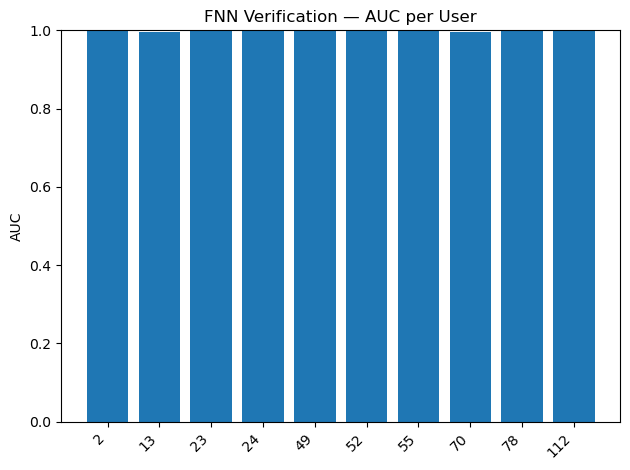

In [210]:
# Optional: save + quick plots for FNN verification results
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

outdir = Path("data/outputs"); outdir.mkdir(parents=True, exist_ok=True)
df_users = pd.DataFrame(user_metrics)
df_users.to_csv(outdir / "fnn_verification_metrics.csv", index=False)
print("Saved:", outdir / "fnn_verification_metrics.csv")

plt.figure()
plt.bar(np.arange(len(df_users)), df_users["AUC"])
plt.xticks(np.arange(len(df_users)), df_users["user"].astype(str), rotation=45, ha="right")
plt.ylabel("AUC"); plt.title("FNN Verification — AUC per User"); plt.ylim(0,1); plt.tight_layout(); plt.show()

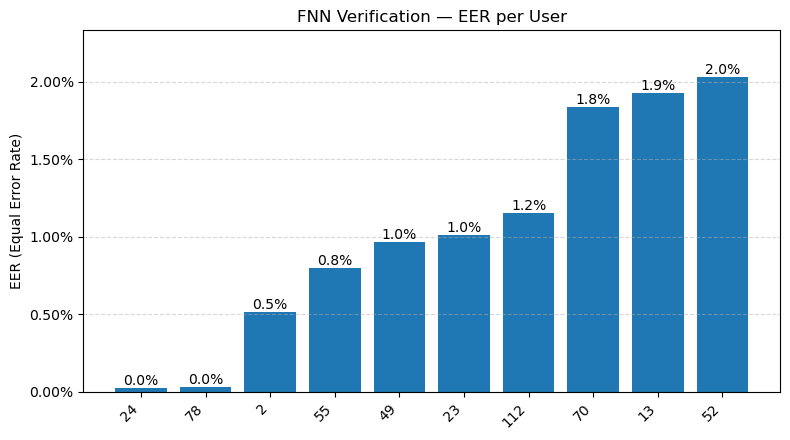

In [211]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Sort users by EER (ascending) for readability
df_eer = df_users.sort_values("EER").reset_index(drop=True)

vals = df_eer["EER"].to_numpy()                # 0..1
names = df_eer["user"].astype(str).to_list()

# Nice y-limits: a little headroom above the max
ymax = float(vals.max()) if len(vals) else 1.0
upper = min(1.0, ymax * 1.15 + 1e-6)           # cap at 1.0

plt.figure(figsize=(8, 4.5))
bars = plt.bar(np.arange(len(vals)), vals)

# Value labels on top of bars
for i, v in enumerate(vals):
    plt.text(i, v, f"{v*100:.1f}%", ha="center", va="bottom")

plt.xticks(np.arange(len(names)), names, rotation=45, ha="right")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

plt.ylim(0, upper)
plt.ylabel("EER (Equal Error Rate)")
plt.title("FNN Verification — EER per User")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [213]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from tensorflow.keras import layers, models, callbacks
import tensorflow as tf

# Optimizer: legacy Adam if available (stabler on some macOS setups)
try:
    from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
    AdamOpt = LegacyAdam
except Exception:
    from tensorflow.keras.optimizers import Adam as AdamOpt

# ---- LSTM builder (assignment constraints: ≤5 LSTM layers, ≤6 units each) ----
def make_lstm_verif_model(timesteps, features, lstm_layers=3, units=6, dropout=0.2):
    assert 1 <= lstm_layers <= 5, "lstm_layers must be 1..5"
    assert units <= 6, "units must be ≤ 6"

    inp = layers.Input(shape=(timesteps, features))
    x = inp
    for i in range(lstm_layers):
        x = layers.LSTM(units, return_sequences=(i < lstm_layers - 1))(x)
        x = layers.Dropout(dropout)(x)

    out = layers.Dense(1, activation="sigmoid")(x)  # binary head
    model = models.Model(inp, out)
    model.compile(
        optimizer=AdamOpt(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
        jit_compile=False
    )
    return model

# ---- Hyperparameters ----
K_VER = 3
EPOCHS = 10
BATCH_SIZE = 64
PATIENCE = 6

timesteps, features = X_scaled.shape[1], X_scaled.shape[2]

lstm_user_metrics = []   # per-user summaries

for user_idx, orig_label in enumerate(le.classes_):
    print(f"\n======================")
    print(f"LSTM Verification — User {user_idx} (orig id: {orig_label})")
    print(f"======================")

    # Binary labels: genuine=1 for this user, impostor=0 otherwise
    y_bin = make_binary_labels(y_idx, target_class_index=user_idx)

    # Stratified CV on binary labels
    splits = get_binary_cv_splits(y_bin, n_splits=K_VER, seed=SEED)

    fold_aucs, fold_eers, fold_fars, fold_frrs = [], [], [], []

    for fold, (tr_idx, va_idx) in enumerate(splits, 1):
        tf.keras.backend.clear_session()

        Xtr, Xva = X_scaled[tr_idx], X_scaled[va_idx]
        ytr, yva = y_bin[tr_idx], y_bin[va_idx]

        # Class weights (keys 0 and 1)
        cw_vals = class_weight.compute_class_weight(
            class_weight="balanced",
            classes=np.array([0, 1], dtype=int),
            y=ytr
        )
        cw = {0: float(cw_vals[0]), 1: float(cw_vals[1])}

        model = make_lstm_verif_model(timesteps, features, lstm_layers=3, units=6, dropout=0.2)

        es = callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
        rlrop = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

        # CPU context avoids metal/XLA quirks on some Macs
        with tf.device("/CPU:0"):
            model.fit(
                Xtr, ytr,
                validation_data=(Xva, yva),
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                class_weight=cw,
                callbacks=[es, rlrop],
                verbose=0
            )

        # Sigmoid scores = acceptance scores for "genuine"
        y_scores = model.predict(Xva, verbose=0).ravel()

        # Metrics
        auc_val = compute_auc(yva, y_scores)
        eer, eer_thr, fars, frrs, thrs = compute_eer(yva, y_scores)
        far_eer, frr_eer = far_frr_at_threshold(yva, y_scores, eer_thr)

        fold_aucs.append(auc_val)
        fold_eers.append(eer)
        fold_fars.append(far_eer)
        fold_frrs.append(frr_eer)

        print(f"  Fold {fold}: AUC={auc_val:.4f} | EER={eer:.4f} | FAR@EER={far_eer:.4f} | FRR@EER={frr_eer:.4f}")

    # Per-user averages across folds
    user_summary = {
        "user": orig_label,
        "AUC": float(np.nanmean(fold_aucs)),
        "EER": float(np.nanmean(fold_eers)),
        "FAR@EER": float(np.nanmean(fold_fars)),
        "FRR@EER": float(np.nanmean(fold_frrs)),
    }
    lstm_user_metrics.append(user_summary)

    print(f"--> User {orig_label} mean over {K_VER} folds | "
          f"AUC={user_summary['AUC']:.4f}, EER={user_summary['EER']:.4f}, "
          f"FAR@EER={user_summary['FAR@EER']:.4f}, FRR@EER={user_summary['FRR@EER']:.4f}")

# ---- Aggregate across all users ----
AUCs  = [m["AUC"] for m in lstm_user_metrics]
EERs  = [m["EER"] for m in lstm_user_metrics]
FARsE = [m["FAR@EER"] for m in lstm_user_metrics]
FRRsE = [m["FRR@EER"] for m in lstm_user_metrics]

print("\n===== LSTM Overall (mean across users) =====")
print(f"Mean AUC: {np.mean(AUCs):.4f} ± {np.std(AUCs):.4f}")
print(f"Mean EER: {np.mean(EERs):.4f} ± {np.std(EERs):.4f}")
print(f"Mean FAR@EER: {np.mean(FARsE):.4f} ± {np.std(FARsE):.4f}")
print(f"Mean FRR@EER: {np.mean(FRRsE):.4f} ± {np.std(FRRsE):.4f}")

# Optional: table
import pandas as pd
df_lstm_users = pd.DataFrame(lstm_user_metrics)
display(df_lstm_users.sort_values("EER"))


LSTM Verification — User 0 (orig id: 2)


2025-10-13 23:40:56.608180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 23:41:24.235945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 23:45:26.765842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 23:45:27.071207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 23:45:27.375482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 23:45:27.573511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 1: AUC=0.9965 | EER=0.0221 | FAR@EER=0.0218 | FRR@EER=0.0225


2025-10-13 23:45:41.442939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 23:46:06.900541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 23:50:11.758944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 23:50:11.925347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 23:50:12.044781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 23:50:12.150456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 2: AUC=0.9850 | EER=0.0779 | FAR@EER=0.0775 | FRR@EER=0.0784


2025-10-13 23:50:19.894770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 23:50:46.818410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 23:54:44.965835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 23:54:45.090536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 23:54:45.212127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 23:54:45.290713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 3: AUC=0.9861 | EER=0.0450 | FAR@EER=0.0450 | FRR@EER=0.0449
--> User 2 mean over 3 folds | AUC=0.9892, EER=0.0483, FAR@EER=0.0481, FRR@EER=0.0486

LSTM Verification — User 1 (orig id: 13)


2025-10-13 23:54:52.377080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 23:55:16.972596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 23:59:25.969445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 23:59:26.253837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 23:59:26.642411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-13 23:59:26.786613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 1: AUC=0.9982 | EER=0.0161 | FAR@EER=0.0160 | FRR@EER=0.0162


2025-10-13 23:59:39.660589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:00:04.912723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:04:30.665613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:04:31.065531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:04:31.398259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:04:31.508148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 2: AUC=0.9984 | EER=0.0160 | FAR@EER=0.0158 | FRR@EER=0.0161


2025-10-14 00:04:40.665918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:05:10.937058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:09:44.153682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:09:44.580646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:09:44.881727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:09:45.070047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 3: AUC=0.9978 | EER=0.0201 | FAR@EER=0.0199 | FRR@EER=0.0202
--> User 13 mean over 3 folds | AUC=0.9982, EER=0.0174, FAR@EER=0.0173, FRR@EER=0.0175

LSTM Verification — User 2 (orig id: 23)


2025-10-14 00:09:54.452257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:10:21.425873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:14:18.881122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:14:19.142923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:14:19.316382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:14:19.431601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 1: AUC=0.9995 | EER=0.0115 | FAR@EER=0.0118 | FRR@EER=0.0111


2025-10-14 00:14:31.432183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:14:56.405368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:18:52.632958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:18:52.808012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:18:52.975432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:18:53.059979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 2: AUC=0.9989 | EER=0.0222 | FAR@EER=0.0222 | FRR@EER=0.0223


2025-10-14 00:19:00.635755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:19:24.912920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:23:36.236451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:23:36.598713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:23:36.822775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:23:37.008356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 3: AUC=0.9995 | EER=0.0106 | FAR@EER=0.0100 | FRR@EER=0.0111
--> User 23 mean over 3 folds | AUC=0.9993, EER=0.0148, FAR@EER=0.0147, FRR@EER=0.0149

LSTM Verification — User 3 (orig id: 24)


2025-10-14 00:23:46.571736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:24:11.959818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:28:13.274496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:28:13.548652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:28:13.706225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:28:13.834085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 1: AUC=0.9982 | EER=0.0125 | FAR@EER=0.0123 | FRR@EER=0.0127


2025-10-14 00:28:27.028462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:28:53.951118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:33:09.491120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:33:09.882161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:33:10.162371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:33:10.347853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 2: AUC=0.9974 | EER=0.0223 | FAR@EER=0.0217 | FRR@EER=0.0228


2025-10-14 00:33:25.487842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:33:56.293836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:38:22.370683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:38:22.706998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:38:22.957297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:38:23.064207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 3: AUC=0.9989 | EER=0.0152 | FAR@EER=0.0152 | FRR@EER=0.0153
--> User 24 mean over 3 folds | AUC=0.9981, EER=0.0167, FAR@EER=0.0164, FRR@EER=0.0169

LSTM Verification — User 4 (orig id: 49)


2025-10-14 00:38:37.844147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:39:04.512454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:43:10.220714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:43:10.557374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:43:10.763529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:43:10.850223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 1: AUC=0.9971 | EER=0.0097 | FAR@EER=0.0097 | FRR@EER=0.0096


2025-10-14 00:43:23.663547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:43:49.470219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:48:22.899690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:48:23.462440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:48:23.721351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:48:23.830145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 2: AUC=0.9965 | EER=0.0169 | FAR@EER=0.0169 | FRR@EER=0.0168


2025-10-14 00:48:34.281584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:49:04.498848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:53:13.082907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:53:13.301919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:53:13.513434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-14 00:53:13.628105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  Fold 3: AUC=0.9961 | EER=0.0115 | FAR@EER=0.0115 | FRR@EER=0.0115
--> User 49 mean over 3 folds | AUC=0.9966, EER=0.0127, FAR@EER=0.0127, FRR@EER=0.0126

LSTM Verification — User 5 (orig id: 52)


2025-10-14 00:53:28.691383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

Saved: /Users/kunal/Code/Biometric Assignment/data/outputs/lstm_verification_metrics.csv

===== LSTM Overall (on available users) =====
Mean AUC: 0.9963 ± 0.0036
Mean EER: 0.0220 ± 0.0133
Mean FAR@EER: 0.0218 ± 0.0132
Mean FRR@EER: 0.0221 ± 0.0134


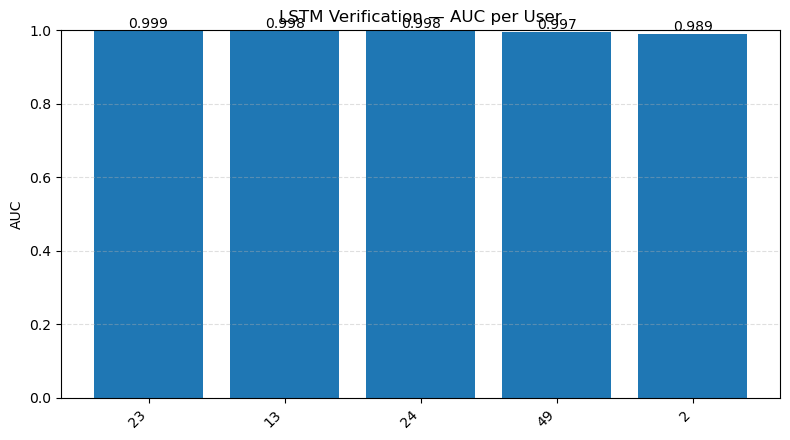

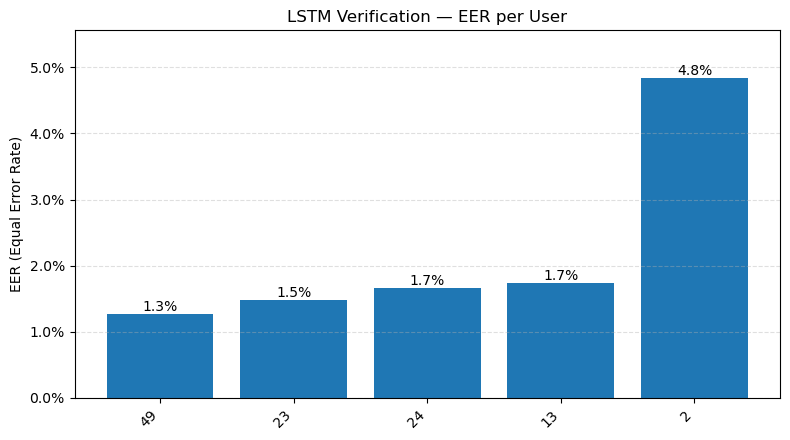

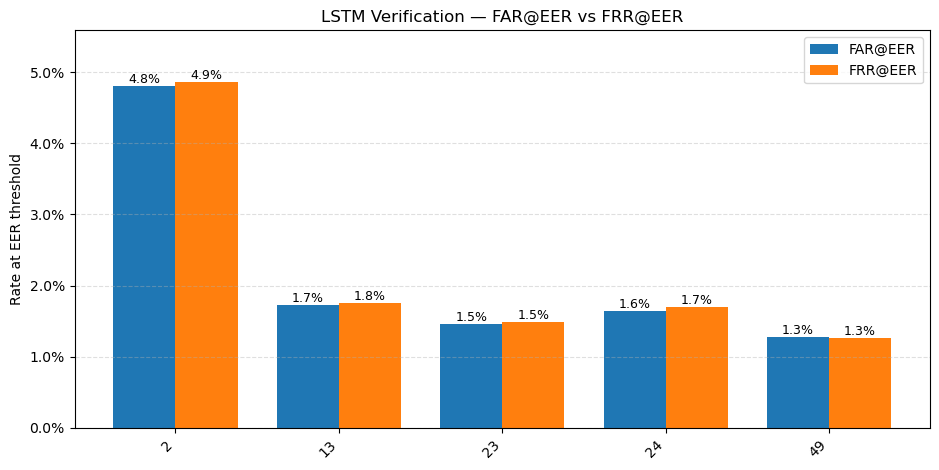

In [214]:
# LSTM verification — metrics table + plots (AUC, EER, FAR@EER, FRR@EER)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from pathlib import Path

# 1) Make a DataFrame from whatever you have so far (even if only some users finished)
assert 'lstm_user_metrics' in globals() and len(lstm_user_metrics) > 0, "No LSTM metrics found. Run the LSTM loop first."
df_lstm_users = pd.DataFrame(lstm_user_metrics).copy()

# Ensure numeric dtypes
for col in ["AUC", "EER", "FAR@EER", "FRR@EER"]:
    df_lstm_users[col] = pd.to_numeric(df_lstm_users[col], errors="coerce")

# 2) Save the table
outdir = Path("data/outputs"); outdir.mkdir(parents=True, exist_ok=True)
csv_path = outdir / "lstm_verification_metrics.csv"
df_lstm_users.to_csv(csv_path, index=False)
print("Saved:", csv_path.resolve())

# 3) Print overall summary on the subset you have
def mean_std(col):
    vals = df_lstm_users[col].dropna().to_numpy()
    return (vals.mean(), vals.std()) if len(vals) else (np.nan, np.nan)

auc_mean, auc_std   = mean_std("AUC")
eer_mean, eer_std   = mean_std("EER")
far_mean, far_std   = mean_std("FAR@EER")
frr_mean, frr_std   = mean_std("FRR@EER")

print("\n===== LSTM Overall (on available users) =====")
print(f"Mean AUC: {auc_mean:.4f} ± {auc_std:.4f}")
print(f"Mean EER: {eer_mean:.4f} ± {eer_std:.4f}")
print(f"Mean FAR@EER: {far_mean:.4f} ± {far_std:.4f}")
print(f"Mean FRR@EER: {frr_mean:.4f} ± {frr_std:.4f}")

# 4) PLOTS
# --- AUC per user (sorted high->low) ---
df_auc = df_lstm_users.sort_values("AUC", ascending=False, na_position="last").reset_index(drop=True)
users_auc = df_auc["user"].astype(str).to_list()
vals_auc = df_auc["AUC"].to_numpy()

plt.figure(figsize=(8, 4.5))
plt.bar(np.arange(len(vals_auc)), vals_auc)
for i, v in enumerate(vals_auc):
    if np.isfinite(v):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
plt.xticks(np.arange(len(users_auc)), users_auc, rotation=45, ha="right")
plt.ylabel("AUC")
plt.title("LSTM Verification — AUC per User")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# --- EER per user (sorted low->high), % axis ---
df_eer = df_lstm_users.sort_values("EER", ascending=True, na_position="last").reset_index(drop=True)
users_eer = df_eer["user"].astype(str).to_list()
vals_eer = df_eer["EER"].to_numpy()
ymax = np.nanmax(vals_eer) if np.isfinite(np.nanmax(vals_eer)) else 1.0
upper = min(1.0, ymax * 1.15 + 1e-6)

plt.figure(figsize=(8, 4.5))
plt.bar(np.arange(len(vals_eer)), vals_eer)
for i, v in enumerate(vals_eer):
    if np.isfinite(v):
        plt.text(i, v, f"{v*100:.1f}%", ha="center", va="bottom")
plt.xticks(np.arange(len(users_eer)), users_eer, rotation=45, ha="right")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.ylim(0, upper)
plt.ylabel("EER (Equal Error Rate)")
plt.title("LSTM Verification — EER per User")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# --- FAR@EER vs FRR@EER (grouped bars) ---
df_err = df_lstm_users.copy()
users_err = df_err["user"].astype(str).to_list()
far_vals = df_err["FAR@EER"].to_numpy()
frr_vals = df_err["FRR@EER"].to_numpy()

x = np.arange(len(users_err))
w = 0.38

plt.figure(figsize=(9.5, 4.8))
plt.bar(x - w/2, far_vals, width=w, label="FAR@EER")
plt.bar(x + w/2, frr_vals, width=w, label="FRR@EER")
for i, (a, b) in enumerate(zip(far_vals, frr_vals)):
    if np.isfinite(a): plt.text(i - w/2, a, f"{a*100:.1f}%", ha="center", va="bottom", fontsize=9)
    if np.isfinite(b): plt.text(i + w/2, b, f"{b*100:.1f}%", ha="center", va="bottom", fontsize=9)

plt.xticks(x, users_err, rotation=45, ha="right")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
top = np.nanmax([np.nanmax(far_vals), np.nanmax(frr_vals)])
top = 1.0 if not np.isfinite(top) else min(1.0, top * 1.15 + 1e-6)
plt.ylim(0, top)
plt.ylabel("Rate at EER threshold")
plt.title("LSTM Verification — FAR@EER vs FRR@EER")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()